In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
from scipy.integrate import solve_ivp
from scipy import optimize
from scipy import linalg
import scipy.optimize as so

In [2]:
# Unless specified otherwise, s will refer to the array representing the susceptible populations. Similarly, for i and r.

Let us say the original transmission matrix is 
$\begin{bmatrix}
b_{11} & b_{12} & b_{13}\\
b_{21} & b_{22} & b_{23}\\
b_{31} & b_{32} & b_{33}
\end{bmatrix}$
$b_{11}$ is the rate at which an individual in group 1 infects another individual in group 1
$b_{12}$ is the rate at which an individual in group 2 infects another individual in group 1 and so on....

An intervention of type 1, leads to a new matrix: 
$\begin{bmatrix}
b_{11}(1-c_1) & b_{12}(1-c_1) & b_{13}(1-c_1)\\ 
b_{21}(1-c_2) & b_{22}(1-c_2) & b_{23}(1-c_2)\\
b_{31}(1-c_3) & b_{32}(1-c_3) & b_{33}(1-c_3)
\end{bmatrix}$
An intervention of type 2, leads to a new matrix: 
$\begin{bmatrix}
b_{11}(1-c_1)^2 & b_{12}(1-c_1)(1-c_2) & b_{13}(1-c_1)(1-c_3)\\ 
b_{21}(1-c_2)(1-c_1) & b_{22}(1-c_2)^2 & b_{23}(1-c_2)(1-c_3)\\
b_{31}(1-c_3)(1-c_1) & b_{32}(1-c_3)(1-c_2) & b_{33}(1-c_3)^2
\end{bmatrix}$

Now, the NGM is just the above matrix elements multiplied by their respective gorup sizes and divided by $\gamma$ (recovery rate).

The final size relations make use of this NGM. So, we choose our required final sizes, and solve for $c_1, c_2, c_3$

In [3]:
#Choose intervention type -- 1 or 2
#Type 1: Intervention creates a protective effect for susceptible. b_ij -> b_ij (1-c_i)
#Type 2: Intervention creates both a protective effect for susceptible and a preventive effect for infectious. b_ij -> b_ij (1-c_i)(1-c_j)

type = 2

#Choose if intervention should only reduce transmission. If false, the transmission may be increased i.e. c can be negative
transmission_reduce = True

In [4]:
def growth_rate(s, b, gamma): #This function returns the growth rate
    B = (b.T * s).T 
    M = B - np.eye(len(s))*gamma #The largest eigenvalue of M is the growth rate of the epidemic
    EV = linalg.eigvals(M)
    gr = np.amax(EV) #Growth rate
    return gr 

In [5]:
def FS(x, b, n, g): ## This function gives the final size using the above defined parameters
    return [x[k] - n[k]*(1-np.exp(-np.sum(b[k]*x/g))) for k in range(len(n))]

In [6]:
def LCFS(a, x): #Expression for linear combination of final sizes 'x'.
    return np.sum(a*x) #a and x are arrays with three elements

In [7]:
def c_typeI(r, b, n):
    #c = np.array([1 + np.log(1-r[0]/n[0])/np.sum(b[0]*r), 1 + np.log(1-r[1]/n[1])/np.sum(b[1]*r), 1 + np.log(1-r[2]/n[2])/np.sum(b[2]*r)])
    c = [1 + np.log(1-r[k]/n[k])/np.sum(b[k]*r) for k in range(len(n))]
    return np.array(c)
    
def c_typeII_eqn(c, b, r, n):
    #return np.array([np.sum(b[0]*(1-c[0])*(1-c)*r) + np.log(1-r[0]/n[0]), np.sum(b[1]*(1-c[1])*(1-c)*r) + np.log(1-r[1]/n[1]), np.sum(b[2]*(1-c[2])*(1-c)*r) + np.log(1-r[2]/n[2])])
    return np.array([np.sum(b[k]*(1-c[k])*(1-c)*r) + np.log(1-r[k]/n[k]) for k in range(len(n))])
    
def c_typeII(r, b, n):
    sol = so.root(c_typeII_eqn, 0.8*np.ones(len(n)), args = (b, r, n)) #Using a numerical solver to find the c values
    return (sol.x, sol.success)
    

b = np.array([[3, 1.25, 2.5], [2.5, 3, 0.9], [1.8, 0.9, 3]])  #Transmission parameters i.e. beta_ij for groups i and j
n = np.array([0.5, 0.35, 0.15]) #Define the sizes of sub-populations
gamma = 1 #Recovery rate
A = np.array([1, 1, 1])


constraint_growth_rate = optimize.NonlinearConstraint(lambda x: growth_rate(n-x, b, gamma), lb=0, ub=0) #since x is final size, we pass the s array = n-x to the growth rate function
if type == 1:
    constraint_reduce_transmission = optimize.NonlinearConstraint(lambda x: c_typeI(x, b, n), ub=1, lb=0)
elif type == 2:
    constraint_reduce_transmission = optimize.NonlinearConstraint(lambda x: c_typeII(x, b, n), ub=1, lb=0)

optimize_ic = 0.9*n

if transmission_reduce == True:
    min_size = optimize.minimize(LCFS, x0 = optimize_ic, args = (A), constraints = (constraint_growth_rate, constraint_reduce_transmission), bounds = [(0, n[0]), (0, n[1]), (0, n[2])])
else:
    min_size = optimize.minimize(LCFS, x0 = optimize_ic, args = (A), constraints = (constraint_growth_rate), bounds = [(0, n[0]), (0, n[1]), (0, n[2])])

if type == 1:
    c = c_typeI(min_size.x, b, n)
    b_c = np.array([b[0]*(1-c[0]), b[1]*(1-c[1]), b[2]*(1-c[2])])  ## The new transmission matrix
elif type == 2:
    c = c_typeII(min_size.x, b, n)
    b_c = np.array([b[0]*(1-c[0])*(1-c), b[1]*(1-c[1])*(1-c), b[2]*(1-c[2])*(1-c)])  ## The new transmission matrix

s_HI = n - min_size.x ## 
r_HI = min_size.x ## This will be the final size that we will aim for during the intervention period.

root_ord = so.root(FS, [0.9, 0.9, 0.9], args = (b, n, gamma)) #Using a numerical solver to find the final size
FS_ord = root_ord.x #The final sizes without intervention

root_int = so.root(FS, [0.1, 0.9, 0.9], args = (b_c, n, gamma))
FS_int = root_int.x #The final sizes with intervention

print(FS_ord, FS_int)

In [8]:
n = np.array([0.7, 0.3]) #Define the sizes of sub-populations
no_g = len(n)
gamma = 1 #Recovery rate
#A = np.array([1, 1, 1]) #Weights of the objective function that is minimized. [1, 1, 1] means the final size of the epidemic is minimized
A = np.array([1, 1])
no_of_trials = 2000 #Number of random trials
b1_list, b2_list, FS_int_list, FS_ord_list = [], [], [], []
for N in range(no_of_trials):
    b1, b2 = np.random.uniform(low = 0, high = 3), np.random.uniform(low = 0, high = 4)
    b = np.array([[b1**2, b1*b2], [b2*b1, b2**2]])
    if growth_rate(n, b, gamma) < 1e-3:
        continue
    #b = np.random.uniform(low = 0, high = 4, size = (no_g, no_g)) #Transmission parameters i.e. beta_ij for groups i and j
    constraint_growth_rate = optimize.NonlinearConstraint(lambda x: growth_rate(n-x, b, gamma), lb=0, ub=0) #since x is final size, we pass the s array = n-x to the growth rate function
    if type == 1:
        constraint_reduce_transmission = optimize.NonlinearConstraint(lambda x: c_typeI(x, b, n), ub=1, lb=0)
    elif type == 2:
        constraint_reduce_transmission = optimize.NonlinearConstraint(lambda x: c_typeII(x, b, n)[0], ub=1, lb=0)
        
    optimize_ic = 0.9*n

    if transmission_reduce == True:
        min_size = optimize.minimize(LCFS, x0 = optimize_ic, args = (A), constraints = (constraint_growth_rate, constraint_reduce_transmission), bounds = [(0, n[k]) for k in range(len(n))])
    else:
        min_size = optimize.minimize(LCFS, x0 = optimize_ic, args = (A), constraints = (constraint_growth_rate), bounds = [(0, n[k]) for k in range(len(n))])

    if type == 1:
        c = c_typeI(min_size.x, b, n)
        b_c = np.array([b[k]*(1-c[k]) for k in range(no_g)])  ## The new transmission matrix
    elif type == 2:
        c, soln_exists = c_typeII(min_size.x, b, n)
        if soln_exists == False:
            continue
        b_c = np.array([b[k]*(1-c[k])*(1-c) for k in range(len(n))])  ## The new transmission matrix
        if (transmission_reduce == True) and (np.any(c<-1e-3)): ## -1e-3 as a threshold instead of zero, allowing for some numerical error.
        #    print('b = ', b)
        #    print('Could not find a valid solution: c = ', c)
            continue

    s_HI = n - min_size.x ## 
    r_HI = min_size.x ## This will be the final size that we will aim for during the intervention period.

    root_ord = so.root(FS, 0.9*n, args = (b, n, gamma)) #Using a numerical solver to find the final size
    FS_ord = root_ord.x #The final sizes without intervention

    root_int = so.root(FS, 0.9*n, args = (b_c, n, gamma))
    FS_int = root_int.x #The final sizes with intervention
    # print('b = ', b)
    # print('c = ', c)
    # print('Final sizes: ', np.sum(FS_ord), np.sum(FS_int))

    b1_list.append(b1)
    b2_list.append(b2)
    FS_int_list.append(np.sum(FS_int))
    FS_ord_list.append(np.sum(FS_ord))
    


C:\Users\Pratyush\Miniconda3\envs\LTURA\lib\site-packages\scipy\optimize\_numdiff.py:579: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
C:\Users\Pratyush\Miniconda3\envs\LTURA\lib\site-packages\scipy\optimize\slsqp.py:427: ComplexWarning: Casting complex values to real discards the imaginary part
  slsqp(m, meq, x, xl, xu, fx, c, g, a, acc, majiter, mode, w, jw,
C:\Users\Pratyush\AppData\Local\Temp/ipykernel_19852/3267254621.py:8: RuntimeWarning: divide by zero encountered in log
  return np.array([np.sum(b[k]*(1-c[k])*(1-c)*r) + np.log(1-r[k]/n[k]) for k in range(len(n))])


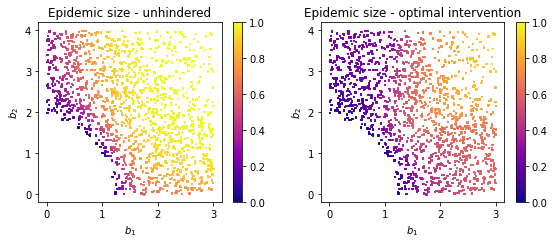

In [9]:
fig, axs = plt.subplots(1, 2, figsize = (16*0.5, 7*0.5)) 
im1 = axs[0].scatter(b1_list, b2_list, c = FS_ord_list, s = 2, marker = 's', cmap = 'plasma', vmin = 0, vmax = 1)
#axs[0].plot(growth_rate_list[0][thresh], growth_rate_list[1][thresh], c = 'k', lw = 1) ##From this curve, we will pick a point for the next simulation
im2 = axs[1].scatter(b1_list, b2_list, c = FS_int_list, s = 2, marker = 's', cmap = 'plasma', vmin = 0, vmax = 1)
fig.colorbar(im1, ax=axs[0])
fig.colorbar(im2, ax=axs[1])

axs[0].set_xlabel(r'$b_1$')
axs[0].set_ylabel(r'$b_2$')
axs[0].set_title(r'Epidemic size - unhindered')
axs[1].set_xlabel(r'$b_1$')
axs[1].set_ylabel(r'$b_2$')
axs[1].set_title(r'Epidemic size - optimal intervention')

fig.tight_layout()

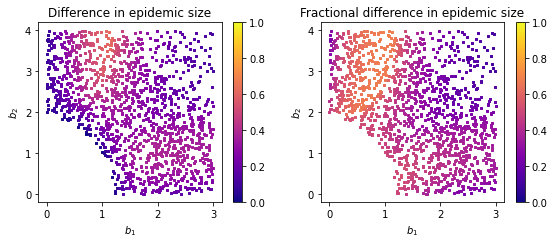

In [10]:
fig, axs = plt.subplots(1, 2, figsize = (16*0.5, 7*0.5)) 
FS_diff_list = np.array(FS_ord_list) - np.array(FS_int_list)
FS_diff_prop_list = FS_diff_list/np.array(FS_ord_list)

im1 = axs[0].scatter(b1_list, b2_list, c = FS_diff_list, s = 4, marker = 's', cmap = 'plasma', vmin = 0, vmax = 1)
im2 = axs[1].scatter(b1_list, b2_list, c = FS_diff_prop_list, s = 4, marker = 's', cmap = 'plasma', vmin = 0, vmax = 1)
#axs[0].plot(growth_rate_list[0][thresh], growth_rate_list[1][thresh], c = 'k', lw = 1) ##From this curve, we will pick a point for the next simulation
#im2 = axs[1].scatter(b1_list, b2_list, c = FS_int_list, s = 4, marker = 's', cmap = 'viridis_r', vmin = 0, vmax = 1)
fig.colorbar(im1, ax=axs[0])
fig.colorbar(im2, ax=axs[1])
axs[0].set_xlabel(r'$b_1$')
axs[0].set_ylabel(r'$b_2$')
axs[0].set_title(r'Difference in epidemic size')

axs[1].set_xlabel(r'$b_1$')
axs[1].set_ylabel(r'$b_2$')
axs[1].set_title(r'Fractional difference in epidemic size')
fig.tight_layout()

In [53]:
%matplotlib widget

fig = plt.figure()
ax1 = fig.add_subplot(projection='3d')
#ax2 = fig.add_subplot(projection='3d')

ax1.scatter(b1_list, b2_list, FS_ord_list, marker='o', s = 1)
ax1.scatter(b1_list, b2_list, FS_int_list, marker='o', s = 1, c = 'rosybrown')
plt.show()
ax1.set_xlabel(r'$b_1$')
ax1.set_ylabel(r'$b_2$')
ax1.set_zlabel('')


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, '')

In [54]:
fig = plt.figure()
ax1 = fig.add_subplot(projection='3d')
#ax2 = fig.add_subplot(projection='3d')

ax1.scatter(b1_list, b2_list, FS_diff_list, marker='o', s = 1, c = 'grey')
plt.show()
ax1.set_xlabel(r'$b_1$')
ax1.set_ylabel(r'$b_2$')
ax1.set_zlabel('Difference')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, 'Difference')

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(projection='3d')
#ax2 = fig.add_subplot(projection='3d')

ax1.scatter(b1_list, b2_list, FS_diff_prop_list, marker='o', s = 1, c = 'slategrey')
plt.show()
ax1.set_xlabel(r'$b_1$')
ax1.set_ylabel(r'$b_2$')
ax1.set_zlabel('Fractional difference')

In [40]:
X = (3, 4)
print(X)
print(X[0])

(3, 4)
3


In [44]:
y, u = X
print(y, u)

3 4


In [31]:
linalg.eigvals([[np.random.uniform(0, 3), np.random.uniform(0, 3)], [np.random.uniform(0, 3), 100]])

array([  2.32988334+0.j, 100.03550929+0.j])

In [23]:
x = [[b_individual[0]**2, b_individual[0]*b_individual[1]], [b_individual[1]*b_individual[0], b_individual[1]**2]]
x

[[array([1.99566675]), array([2.89813327])],
 [array([2.89813327]), array([4.20870691])]]

In [19]:
b = np.random.uniform(low = 0, high = 4, size = (no_g, no_g)) #Transmission parameters i.e. beta_ij for groups i and j
b

array([[0.21126853, 0.15741859],
       [3.53953825, 0.70804284]])

def SIR3(t, X, b, g): ##Define the dynamical equations for SIR model with 3 groups and arbitrary transmission
    S = X[0:3]
    I = X[3:6]
    R = X[6:9]
    return np.array([-S[0]*(b[0, 0]*I[0] + b[0, 1]*I[1] + b[0, 2]*I[2]), 
    -S[1]*(b[1, 0]*I[0] + b[1, 1]*I[1] + b[1, 2]*I[2]), 
    -S[2]*(b[2, 0]*I[0] + b[2, 1]*I[1] + b[2, 2]*I[2]),
    S[0]*(b[0, 0]*I[0] + b[0, 1]*I[1] + b[0, 2]*I[2]) - g*I[0], 
    S[1]*(b[1, 0]*I[0] + b[1, 1]*I[1] + b[1, 2]*I[2]) - g*I[1], 
    S[2]*(b[2, 0]*I[0] + b[2, 1]*I[1] + b[2, 2]*I[2]) - g*I[2],
    g*I[0], 
    g*I[1],
    g*I[2]])

eps_i = 0.005 ## Threshold for i(t) at which intervention is imposed
eps_f = 0.5*1e-3 ## Threshold for i(t) below which intervention is released
ti = 0
tf = 80
dt = 0.05
T = np.arange(ti, tf, dt)
X_init = [n[0] - 1/3*1e-3, n[1] - 1/3*1e-3, n[2] - 1/3*1e-3, 1/3*1e-3, 1/3*1e-3, 1/3*1e-3, 0, 0, 0] # Initial conditions
# 1/3*1e-3 is i(0) for each of the groups.

SOL_ord = solve_ivp(SIR3, [ti, tf], X_init, t_eval = T, args = (b, gamma)) # The ordinary trajectory (without intervention)
t_int_idx = np.where(SOL_ord.y[3]+SOL_ord.y[4]+SOL_ord.y[5]-eps_i>=0)[0][0] ##Index value of time at which i(t) crossing eps_i
t_int = T[t_int_idx] ## Time at which i(t) crosses eps_i
X_init_int = SOL_ord.y[:, t_int_idx] ## The initial conditions for the intervention

## Now we implement the intervention
SOL_int = solve_ivp(SIR3, [t_int, tf], X_init_int, t_eval = np.arange(t_int, tf, dt), args = (b_c, gamma)) 
t_rel_idx = np.where(SOL_int.y[3] + SOL_int.y[4] + SOL_int.y[5] < eps_f)[0][0] ## Index value of time where i(t) reaching eps_f
t_rel = SOL_int.t[t_rel_idx]  ## Time at which i(t) crosses eps_f, and intervention is released
X_init_rel = SOL_int.y[:, t_rel_idx] ##Initial conditions for releasing the interventions
SOL_rel = solve_ivp(SIR3, [t_rel, tf], X_init_rel, t_eval = np.arange(t_rel, tf-dt, dt), args = (b, gamma)) #Trajectory post intervention

fig, axs = plt.subplots(1, 2, figsize = (17*0.8, 5*0.8), dpi = 100)
#plt.suptitle(r'$\beta: %.2f$, $\gamma: %.2f$, $c: %.3f$'%(beta, gamma, c))

clrs = ['r', 'g', 'b']
for j, idx in enumerate([6, 7, 8]):
    axs[0].plot(T, SOL_ord.y[idx].T, c = clrs[j], ls = ':', label = r'$r$, Group: %d'%j, lw = 0.75)
    axs[0].plot(SOL_int.t, SOL_int.y[idx].T, c = clrs[j], ls = '--', lw = 0.75)
    axs[0].plot(SOL_rel.t, SOL_rel.y[idx].T, c = clrs[j], ls = '-', lw = 0.75)
# for j, idx in enumerate([0, 1, 2]):
#     axs[0].plot(T, SOL_ord.y[idx].T, c = clrs[j], ls = ':', label = r'$s$, Group: %d'%j, lw = 0.75)
#     axs[0].plot(SOL_int.t, SOL_int.y[idx].T, c = clrs[j], ls = '--', lw = 0.75)
#     axs[0].plot(SOL_rel.t, SOL_rel.y[idx].T, c = clrs[j], ls = '-', lw = 0.75)
for j, idx in enumerate([3, 4, 5]):
    axs[1].plot(T, SOL_ord.y[idx].T, c = clrs[j], ls = ':', label = r'$i$, Group: %d'%j, lw = 0.9)
    axs[1].plot(SOL_int.t, SOL_int.y[idx].T, c = clrs[j], ls = '--', lw = 0.9)
    axs[1].plot(SOL_rel.t, SOL_rel.y[idx].T, c = clrs[j], ls = '-', lw = 0.9)

axs[0].yaxis.tick_right()
axs[0].legend(loc = 'upper left')
axs[1].legend()
axs[0].set_xlim(0, 60)
axs[1].set_xlim(0, 25)
fig.tight_layout()

root = so.root(FS, [0.9, 0.9, 0.9], args = (b, n, gamma)) #Using a numerical solver to find the final size
FS_ord = root.x #The three final sizes


print('Size of the groups: ', n)
print('Original Transmission Matrix: \n', b)
print('Final Sizes for the ordinary epidemic: ', FS_ord, '; Total: ', np.sum(FS_ord))
print('Herd Immunity Point: s = ', s_HI)
print('c = ', c)
print('Transmission Matrix with intervention: \n', np.round(b_c, 3))
print('Expected final size due to intervention: r = ', r_HI, '; Total: ', np.sum(r_HI))
print('Observed final size due to intervention: r = ', SOL_rel.y[6:9, -1], '; Total: ', np.sum(SOL_rel.y[6:9, -1]))
print('Details of the figure: dotted line is the original trajectory, dashed line is the intervention, orindary line is post intervention')